In [9]:
using Pkg
Pkg.activate(".")
import PowerModels as PM
import MathOptInterface as MOI
import JSON 
import Glob
using LinearAlgebra: cond
using Plots
const SOLVED_STATUSES = [MOI.OPTIMAL, MOI.LOCALLY_SOLVED, MOI.ALMOST_OPTIMAL, MOI.ALMOST_LOCALLY_SOLVED]
include("cpf_data/utils.jl")
PM.silence()

  Activating project at `~/Documents/Projects/pfdelta/data_generation`


In [10]:
root = "final_data_no_exp/case500/n-2/close2inf_train"
solved_cases_path = joinpath(root, "around_nose") 
sample_nums = [47, 9903, 15802]

# Initialize arrays
files = Dict(sample => Glob.glob("sample_$(sample)_*.json", solved_cases_path) for sample in sample_nums)

# Results 
results = Dict{Int64, Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}}()

Dict{Int64, Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}}()

In [11]:
# Power flow jacobian
for sample in sample_nums
    results[sample] = Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}()  # initialize inner dict
    for file in files[sample]
        json_dict = JSON.parsefile(file) # it's not going to be the whole json file
        lam = json_dict["lambda"]
        net = json_dict["solved_net"]

        # Build Jacobian and get condition number
        net = PM.make_basic_network(net)
        J = PM.calc_basic_jacobian_matrix(net)

        # Try to solve NR from a flat start
        pf_solution = PM.compute_ac_pf(net; flat_start=true)
        converged =  pf_solution["termination_status"] in SOLVED_STATUSES
        iterations = pf_solution["iterations"]
        solve_time = pf_solution["solve_time"]
        
        # Save results
        results[sample][lam] = (cond(Array(J), 2), converged, iterations, solve_time)
    end
end

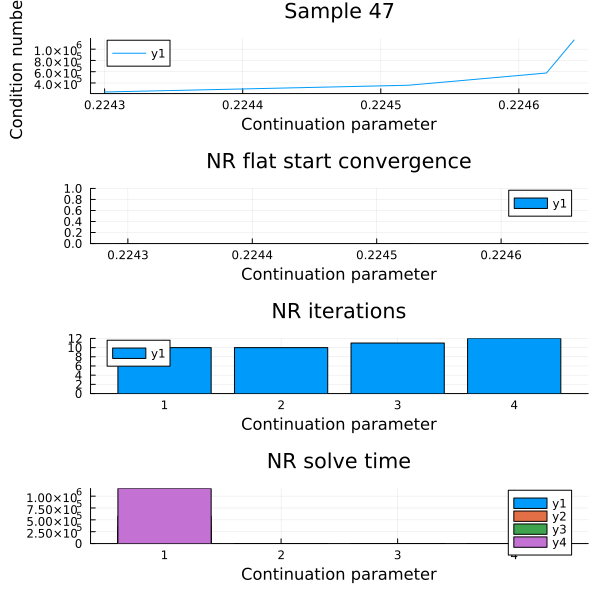

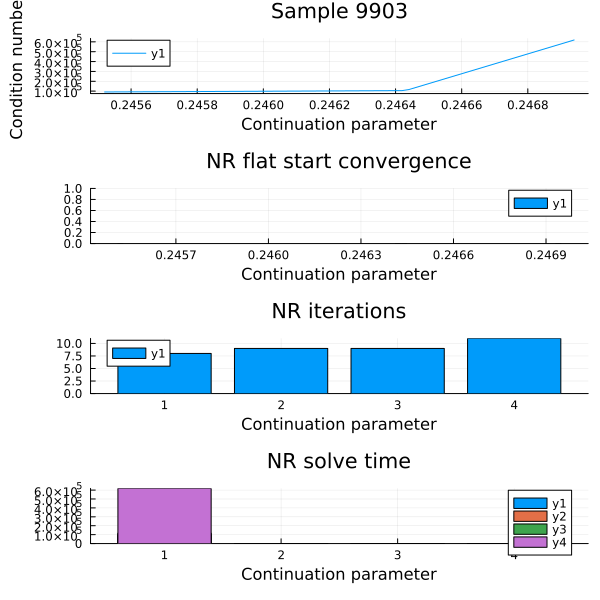

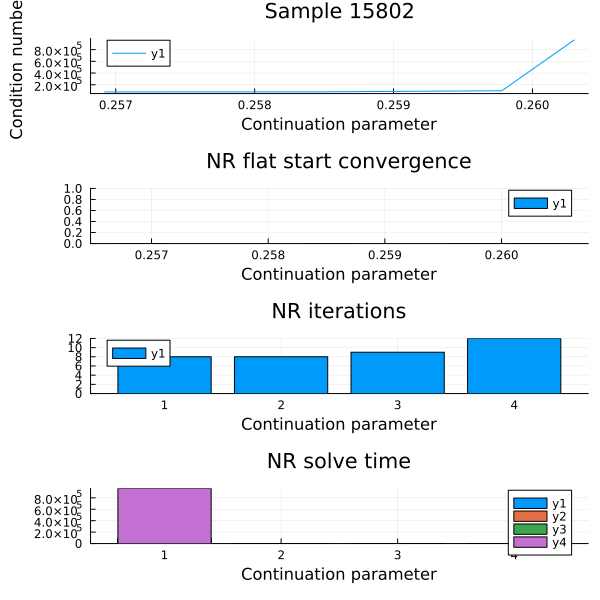

In [12]:
# Plots for the around the nose points
for sample in sample_nums
    sample_results = results[sample]
    lams = sort(collect(keys(sample_results)))
    vals = [sample_results[lam] for lam in lams]

    cond_nums = first.(vals)
    convergence = getindex.(vals, 2)
    iterations = getindex.(vals, 3)
    solve_time = last.(vals, 4)

    p1 = plot(lams, cond_nums, title = "Sample $sample", ylabel="Condition number", xlabel="Continuation parameter")
    p2 = bar(lams, convergence, title="NR flat start convergence", xlabel="Continuation parameter")
    p3 = bar(1:length(iterations), iterations, title="NR iterations", xlabel="Continuation parameter")
    p4 = bar(1:length(solve_time), solve_time, title="NR solve time", xlabel="Continuation parameter")
    fig = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 600))
    display(fig)
end

In [13]:
# Plots for all point created with continuation power flow  
results = Dict{Int64, Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}}()
pv_curve_data = Dict{Int64, Dict{Float64, Dict}}()
raw_path = joinpath(root, "raw")
for sample in sample_nums
    results[sample] = Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}()
    pv_curve_data[sample] = Dict{Float64, Dict}()
    get_condition_num_and_NR(results, raw_path, sample, pv_curve_data)
end

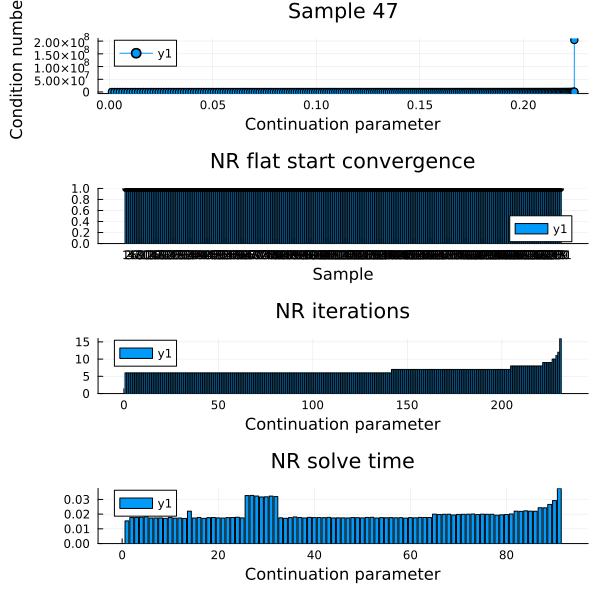

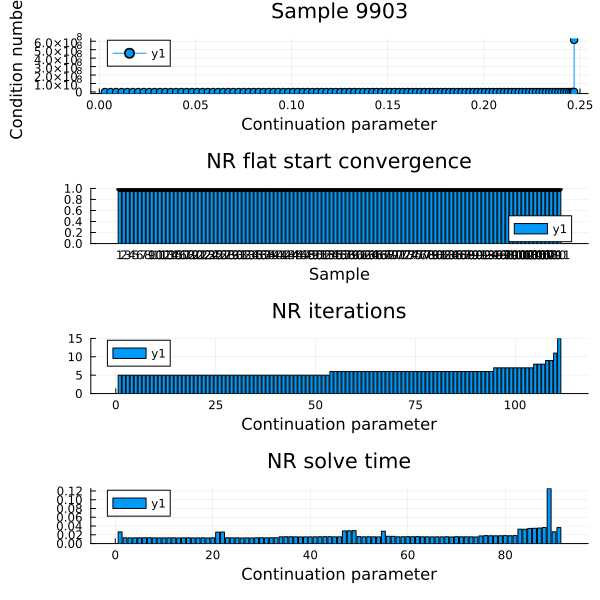

BoundsError: BoundsError: attempt to access 88-element Vector{Float64} at index [-2:88]

In [14]:
for sample in sample_nums
    sample_results = results[sample]
    lams = sort(collect(keys(sample_results)))
    vals = [sample_results[lam] for lam in lams]

    cond_nums = first.(vals)
    convergence = getindex.(vals, 2)
    iterations = getindex.(vals, 3)
    solve_time = last.(vals)

    p1 = plot(lams, cond_nums, title = "Sample $sample", ylabel="Condition number", xlabel="Continuation parameter", marker = :circle)
    p2 = bar(1:length(convergence), convergence, title="NR flat start convergence", xlabel="Sample", xticks=1:length(convergence))
    scatter!(1:length(convergence), convergence, markershape=:circle, color=:black, label="")  
    p3 = bar(1:length(iterations), iterations, title="NR iterations", xlabel="Continuation parameter")
    p4 = bar(1:length(solve_time[end-90:end]), solve_time[end-90:end], title="NR solve time", xlabel="Continuation parameter")

    fig = plot(p1, p2, p3, p4, layout = (4, 1), size = (600, 600))
    display(fig)
end

1.07499757
1.07983639
1.07709699
1.06949658
1.07321388
1.07246646
1.07085855
1.07524369
1.07654043
1.07173718
1.07568944
1.07260532
1.07740242
1.07187236
1.07056252
1.070438
1.07297856
1.07689409
1.0767423
1.0716475
1.07973142
1.07081582
1.07669177
1.06992031
1.07470371
1.07251268
1.07509589
1.07431453
1.07588863
1.07133657
1.06952837
1.06930132
1.07730047
1.06931562
1.07899997
1.07485044
1.07265175
1.07307251
1.07146924
1.07578895
1.07124863
1.07842949
1.07138069
1.06935658
1.07931272
1.06943615
1.07559008
1.07279142
1.07416939
1.07583877
1.0739285
1.07412111
1.07330843
1.06984484
1.07142492
1.07182722
1.0791041
1.07288486
1.07765792
1.07853293
1.07237424
1.07786294
1.07446011
1.07064635
1.07822301
1.07373672
1.07770912
1.0730255
1.07151367
1.07735143
1.07450874
1.07480148
1.07364116
1.07514511
1.07047933
1.07345069
1.0746549
1.06988239
1.07894795
1.07745345
1.07388047
1.07957419
1.07978389
1.07608848
1.07129255
1.07359346
1.07704621
1.07529305
1.0692937
1.07941722
1.07475257
1.073545

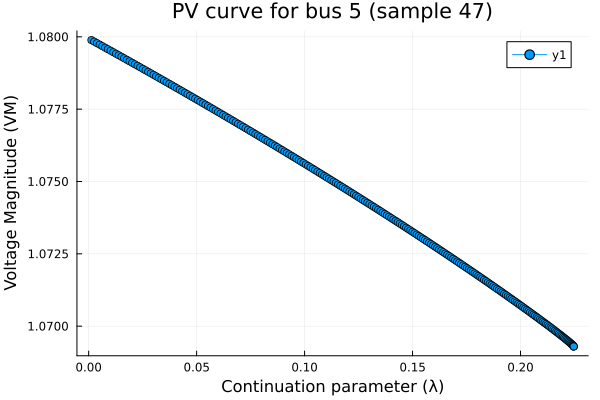

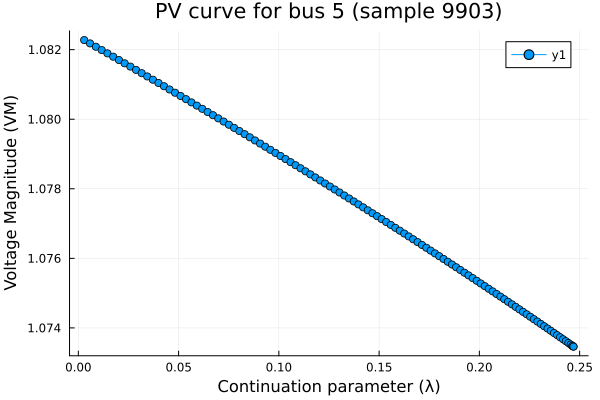

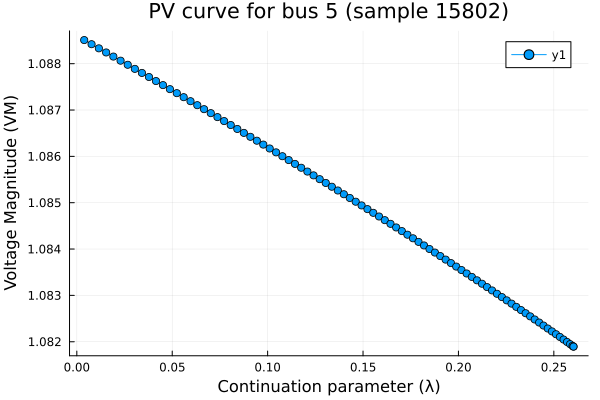

In [15]:
# Plot PV curve
selected_bus = 5  # must be a PQ bus
for sample in sample_nums
    lam_vm_pairs = Vector{Tuple{Float64, Float64}}()
    
    for (lam, net) in pv_curve_data[sample]
        vm = net["bus"][string(selected_bus)]["vm"]
        println(vm)
        push!(lam_vm_pairs, (lam, vm))
    end

    sorted_pairs = sort(lam_vm_pairs, by = x -> x[1])
    lams = [x[1] for x in sorted_pairs]
    vms = [x[2] for x in sorted_pairs]
    println(lams)
    println(vms)

    p1 = plot(lams, vms,
              title = "PV curve for bus $selected_bus (sample $sample)",
              ylabel = "Voltage Magnitude (VM)",
              xlabel = "Continuation parameter (λ)",
              marker = :circle)
    display(p1)
end    